# STT model training

## Imports + model creation

In [1]:
import pandas as pd
import tensorflow as tf

from models.stt import DeepSpeech, Jasper, TransformerSTT
from datasets import get_dataset, train_test_split, prepare_dataset, test_dataset_time
from utils import plot_spectrogram
from utils.text import get_symbols
from utils.audio import display_audio, load_audio, load_mel

gpus = tf.config.list_physical_devices('GPU')

model_name = "casper"


print("Tensorflow version : {}".format(tf.__version__))
print("Available GPU's ({}) : {}".format(len(gpus), gpus))

Tensorflow version : 2.5.0
Available GPU's (1) : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
model = Jasper.build_from_jasper_pretrained()
print(model)

Initializing submodel : stt_model !
Submodel stt_model saved in pretrained_models\pretrained_jasper\saving\stt_model.json !


Model pretrained_jasper initialized successfully !
Weights transfered successfully !
Submodel stt_model saved in pretrained_models\pretrained_jasper\saving\stt_model.json !

========== pretrained_jasper ==========
Sub model stt_model
- Inputs 	: (None, None, 64)
- Outputs 	: (None, None, 29)
- Number of layers 	: 280
- Number of parameters 	: 332.754 Millions
- Model not compiled

Transfer-learning from : pretrained_jasper
Already trained on 0 epochs (0 steps)

Language : en
Audio rate : 16000
Mel channels : 64
Use CTC decoder : True
Output vocab (size = 29) : [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '']



In [4]:
cleaners = ['french_cleaners']

vocab = get_symbols('fr', maj = False, punctuation = 0)
print(vocab)

['_', '-', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'é', 'è', 'ê', 'î', 'ç', 'ô', 'ù']


In [5]:
model = Jasper.build_from_jasper_pretrained(
    nom = model_name, lang = 'fr', vocab = vocab, cleaners = cleaners
)
print(model)

Initializing submodel : stt_model !
Submodel stt_model saved in pretrained_models\casper\saving\stt_model.json !
Model casper initialized successfully !
Variables 540 shapes mismatch ((1, 1024, 37) vs (1, 1024, 29)), making partial transfer
Variables 541 shapes mismatch ((37,) vs (29,)), making partial transfer
Weights transfered successfully !
Submodel stt_model saved in pretrained_models\casper\saving\stt_model.json !

========== casper ==========
Sub model stt_model
- Inputs 	: (None, None, 64)
- Outputs 	: (None, None, 37)
- Number of layers 	: 280
- Number of parameters 	: 332.763 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

Language : fr
Audio rate : 16000
Mel channels : 64
Use CTC decoder : True
Output vocab (size = 37) : ['_', '-', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'é', 'è', 'ê', 'î', 'ç', 'ô', 'ù']



In [ ]:
model = DeepSpeech.build_from_deep_speech_pretrained(
    nom = model_name, lang = 'fr', vocab = vocab, cleaners = cleaners
)
print(model)

In [ ]:
config = {
    'embedding_dim'      : 512,
    'encoder_num_layers' : 4,
    'encoder_mha_num_heads' : 2,
    'decoder_num_layers' : 1,
    'decoder_mha_num_heads' : 2,
    'encoder_enc_mha_num_heads' : 2,
}
model = TransformerSTT(lang = 'fr', nom = model_name)

In [ ]:
print(model.text_encoder)

## Model initialization

In [2]:
model = Jasper(nom = model_name)

lr_config = {
    'name' : 'WarmupScheduler',
    'maxval' : 1e-3,
    'minval' : 1e-4,
    'factor' : 256,
    'warmup_steps' : 275 * 10
}
lr_config = 5e-4

model.compile(
    optimizer = 'adam', 
    optimizer_config = {
        'lr' : lr_config
    }
)

print(model)

Model restoration...
Initializing submodel : stt_model !
Optimizer 'stt_model_optimizer' initilized successfully !
Submodel stt_model compiled !
  Loss : {'reduction': 'auto', 'name': 'CTCLoss', 'pad_value': 0}
  Optimizer : {'name': 'Adam', 'learning_rate': 0.0005000000237487257, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : [{'name': 'TextMetrics', 'dtype': 'float32', 'pad_value': 0}]
Successfully restored stt_model from pretrained_models/casper/saving/stt_model.json !
Model casper initialized successfully !
Model stt_model is already compiled !

========== casper ==========
Sub model stt_model
- Inputs 	: (None, None, 64)
- Outputs 	: (None, None, 37)
- Number of layers 	: 280
- Number of parameters 	: 332.763 Millions
- Optimizer 	: {'name': 'Adam', 'learning_rate': 0.0005000000237487257, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
- Loss 	 :

In [3]:
dataset_name = ['siwis', 'voxforge', 'common_voice']
dataset = get_dataset(dataset_name, accent = 'france')

train, valid = None, None

print("Dataset length : {}".format(len(dataset)))

Loading dataset siwis...
Loading dataset voxforge...
Loading dataset common_voice...
Dataset length : 299207


## Training

In [ ]:
for layer in model.layers[:-2]:
    layer.trainable = True
model.summary()

In [4]:
""" Classic hyperparameters """
epochs     = 5
batch_size = 32
valid_batch_size = 2 * batch_size
train_prop = 0.9
train_size = min(1024 * 3 * batch_size, int(len(dataset) * train_prop))
valid_size = min(len(dataset) - train_size, 250 * batch_size)

shuffle_size    = batch_size * 16
pred_step       = -1 # make a prediction after every epoch
augment_prct    = 0.25

""" Custom training hparams """
trim_audio      = False
reduce_noise    = False
trim_threshold  = 0.075
max_silence     = 0.25
trim_method     = 'window'
trim_mode       = 'start_end'

trim_mel     = False
trim_factor  = 0.6
trim_mel_method  = 'max_start_end'

max_input_length = 256 * 3

""" Training """

# this is to normalize dataset usage so that you can use a pre-splitted dataset or not
# without changing anything in the training configuration
if train is None or valid is None:
    train, valid = train_test_split(
        dataset, train_size = train_size, valid_size = valid_size, shuffle = True
    )

print("Training samples   : {} - {} batches".format(
    len(train), len(train) // batch_size
))
print("Validation samples : {} - {} batches".format(
    len(valid), len(valid) // valid_batch_size
))

model.train(
    train, validation_data = valid,

    epochs = epochs, batch_size = batch_size, valid_batch_size = valid_batch_size,
    
    pred_step = pred_step, shuffle_size = shuffle_size, augment_prct = augment_prct,
    
    trim_audio = trim_audio, reduce_noise = reduce_noise, trim_threshold = trim_threshold,
    max_silence = max_silence, trim_method = trim_method, trim_mode = trim_mode,
    
    trim_mel = trim_mel, trim_factor = trim_factor, trim_mel_method = trim_mel_method,
    
    max_input_length = max_input_length
)

Training samples   : 98304 - 3072 batches
Validation samples : 8000 - 125 batches
Training config :
HParams :
- augment_prct	: 0.25
- max_input_length	: 768
- max_output_length	: None
- trim_audio	: False
- reduce_noise	: False
- trim_threshold	: 0.075
- max_silence	: 0.25
- trim_method	: window
- trim_mode	: start_end
- trim_mel	: False
- trim_factor	: 0.6
- trim_mel_method	: max_start_end
- epochs	: 30
- batch_size	: 32
- valid_batch_size	: 64
- test_batch_size	: 1
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1
- shuffle_size	: 512

Epoch 26/30
    878/Unknown - 3603s 4s/step - loss: 0.6620 - edit_distance: 34.1347
Saving after 1 hour training !
   1739/Unknown - 7213s 4s/step - loss: 0.6645 - edit_distance: 34.2342
Saving after 1 hour training !
   2549/Unknown - 10829s 4s/step - loss: 0.6745 - edit_distance: 34.3758
Saving after 1 hour training !
2931/2931 [==============================] - 13524s 5s/step -

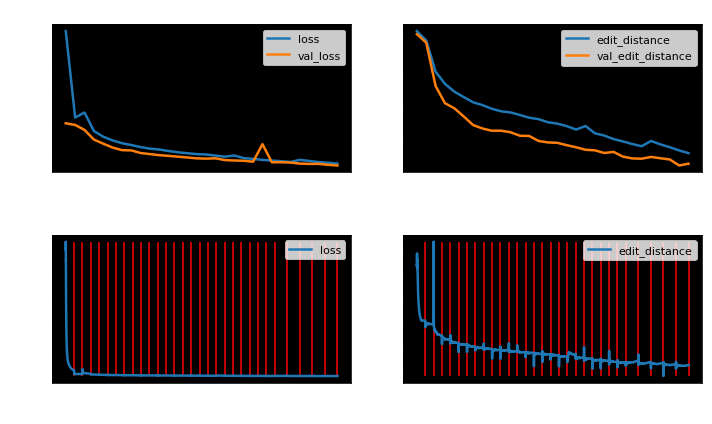

===== History =====
    edit_distance      loss  val_edit_distance  val_loss
0       50.854950  5.152933          50.420601  1.981690
1       49.505146  2.180229          49.190105  1.924781
2       45.021069  2.350878          42.960983  1.753729
3       43.270844  1.716083          40.495403  1.421280
4       42.153442  1.518834          39.759853  1.279706
5       41.378918  1.392893          38.588150  1.146598
6       40.626663  1.295744          37.355621  1.056450
7       40.218357  1.233099          36.856018  1.048205
8       39.690426  1.161356          36.540726  0.957780
9       39.326641  1.108520          36.540989  0.920851
10      39.166206  1.076736          36.317657  0.884108
11      38.796997  1.026765          35.814896  0.858897
12      38.405731  0.981998          35.779560  0.832488
13      38.202888  0.950420          35.058331  0.803853
14      37.750256  0.921329          34.855885  0.774338
15      37.554836  0.906866          34.800182  0.765450
16      37.

In [5]:
model.plot_history()
print(model.history)

## Dataset analysis

In [7]:
config = model.get_dataset_config(batch_size = 32, is_validation = False, shuffle_size = 0)
ds = prepare_dataset(valid, ** config, debug = True)

test_dataset_time(ds)

Original dataset : <TensorSliceDataset shapes: {dataset: (), filename: (), id: (), text: (), time: (), wavs_16000: (), wavs_22050: ()}, types: {dataset: tf.string, filename: tf.string, id: tf.string, text: tf.string, time: tf.float32, wavs_16000: tf.string, wavs_22050: tf.string}>
- Dataset after encoding : <ParallelMapDataset shapes: ((None, 64), (), (None,), ()), types: (tf.float32, tf.int32, tf.int32, tf.int32)>
- Dataset after filtering : <FilterDataset shapes: ((None, 64), (), (None,), ()), types: (tf.float32, tf.int32, tf.int32, tf.int32)>
- Dataset after augmentation : <ParallelMapDataset shapes: ((None, 64), (), (None,), ()), types: (tf.float32, tf.int32, tf.int32, tf.int32)>
- Dataset after batch : <PaddedBatchDataset shapes: ((None, None, 64), (None,), (None, None), (None,)), types: (tf.float32, tf.int32, tf.int32, tf.int32)>
- Dataset after mapping : <ParallelMapDataset shapes: (((None, None, 64), (None,)), ((None, None), (None,))), types: ((tf.float32, tf.int32), (tf.int32,

99it [00:20,  4.85it/s]


100 batchs in 20.436 sec sec (4.893 batch / sec)
Batch infos : 
Element 0 : 
 Element 0 : shape : (32, 767, 64) - type : <dtype: 'float32'> - min : -9.723 - max : 5.242
 Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 542.000 - max : 767.000
Element 1 : 
 Element 0 : shape : (32, 80) - type : <dtype: 'int32'> - min : 0.000 - max : 37.000
 Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 4.000 - max : 80.000


20.435730934143066

Original dataset : <TensorSliceDataset shapes: {dataset: (), filename: (), id: (), text: (), time: (), wavs_16000: (), wavs_22050: ()}, types: {dataset: tf.string, filename: tf.string, id: tf.string, text: tf.string, time: tf.float32, wavs_16000: tf.string, wavs_22050: tf.string}>
- Dataset after encoding : <ParallelMapDataset shapes: ((None, 64), (), (None,), ()), types: (tf.float32, tf.int32, tf.int32, tf.int32)>
- Dataset after filtering : <FilterDataset shapes: ((None, 64), (), (None,), ()), types: (tf.float32, tf.int32, tf.int32, tf.int32)>
- Dataset after batch : <PaddedBatchDataset shapes: ((None, None, 64), (None,), (None, None), (None,)), types: (tf.float32, tf.int32, tf.int32, tf.int32)>
- Dataset after mapping : <ParallelMapDataset shapes: (((None, None, 64), (None,)), ((None, None), (None,))), types: ((tf.float32, tf.int32), (tf.int32, tf.int32))>
Encoded text : [ 7 14 14  7  2  3  2 18 14 23 21  2 22  3 20  6  2 30 22 30  2 20  7  5
 17 16 21 22 20 23 11 22  7  2 18  3 20 

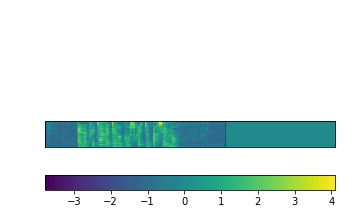

Encoded text : [ 3  2 18 20  7 15 11 31 20  7  2 24 23  7  2 24 17 14 22  3 11 20  7  2
 21  7 15  4 14  7  2 11 16  3 18 22  7  2  3  2 14  3  2 20 30  6  3  5
 22 11 17 16  2  6  7  2  5  7  2 22 27 18  7  2  6  7  2 20 17 15  3 16
 21]
Decoded text : a première vue voltaire semble inapte a la rédaction de ce type de romans
Predicted : a première vu tvoltèr semble ina a la rédaction de ce type de roman


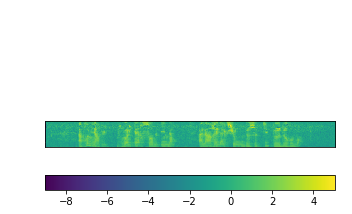

Encoded text : [11 14  2  3 18 18 20  7 16  6  2 14 10 17 20 22 11  5 23 14 22 23 20  7
  2  3  2 14 17 20  3 16  9  7 20  3 11  7  2  9 20  3 16  6  1  6 23  5
  3 14  7  2  6  7  2  9 17 22 10  3]
Decoded text : il apprend lhorticulture a lorangeraie grand-ducale de gotha
Predicted : il apprend leursiculture alorangeai grandduca de gota


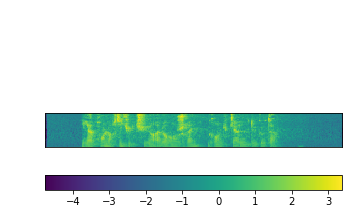

Encoded text : [11 14  2 21  3  9 11 22  2  6 23 16  2  6 30  5 17  6  3  9  7  2 18  3
 20  2  3 16 16 23 14  3 22 11 17 16 21  2 21 23  5  5  7 21 21 11 24  7
 21  0  0  0  0  0  0  0  0  0  0  0]
Decoded text : il sagit dun décodage par annulations successives
Predicted : il sagit dun décodage par anulation duccesi


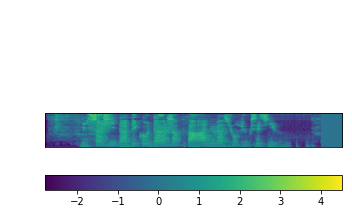

Encoded text : [20 17 16  2  5  3 20 22  7 20  2  7 21 22  2  6  7 24  7 16 23  2  5 30
 14 31  4 20  7  2  7 16  2 12 17 23  3 16 22  2  3 24  7  5  2 15 11 14
  7 21  2  6  3 24 11 21  0  0]
Decoded text : ron carter est devenu célèbre en jouant avec miles davis
Predicted : rene qarteur deveni télèbres enjou avec mahe devis


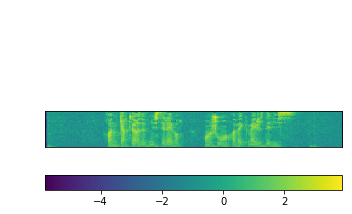

Encoded text : [11 14  2  7 21 22  2  7 16 22 17 23 20 30  2  6  7  2  6 17 23 24  7 21
  2  7 22  2 14 17 16  2 27  2  3  5  5 31  6  7  2 18  3 20  2 23 16  2
 18 17 16 22  1 14  7 24 11 21]
Decoded text : il est entouré de douves et lon y accède par un pont-levis
Predicted : il est entouré de douve et lon ny accède par un ponnevi


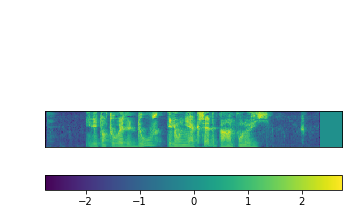

Encoded text : [15  3 22 11 31 20  7  2  5 30 20 30  4 20  3 14  7  2  5 17 15 18 14 31
 22  7 15  7 16 22  2 17 23  2  7 16  2 18  3 20 22 11  7  2 21 17 20 22
 11  7  2  6 23  2  5 20  3 16  7]
Decoded text : matière cérébrale complètement ou en partie sortie du crane
Predicted : matière séré vra le complètement ou en parti surti du grane


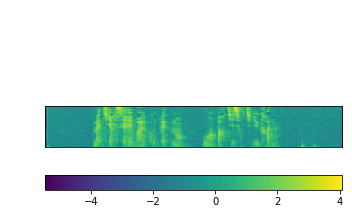

Encoded text : [17 16  2 14 23 11  2  6 11 22  2  6  7 16 22 20  7 20  2  5 10  7 28  2
 14  7  2 12 23  9  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]
Decoded text : on lui dit dentrer chez le juge
Predicted : on lui dit dentréchezr le juge


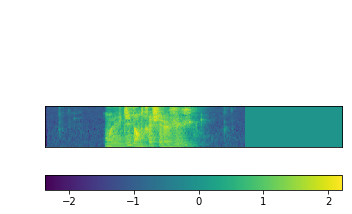

Encoded text : [11 14 21  2 21 17 16 22  2 14  7 16 22 21  2  7 22  2  6 11  9 16  7 21
  2  6  3 16 21  2 14  7 23 20 21  2 15 17 23 24  7 15  7 16 22 21  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Decoded text : ils sont lents et dignes dans leurs mouvements
Predicted : il sont lan et digne dans leurbougement


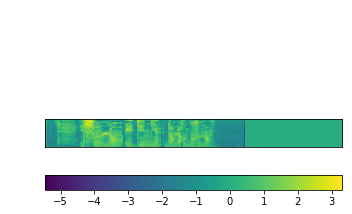

Encoded text : [14  7  2  5 17 16 21  7 11 14  2 15 23 16 11  5 11 18  3 14  2 18 20 30
  8 31 20  7  2  3 14 17 20 21  2 24  7 16  6 20  7  2  5  7 20 22  3 11
 16 21  2 30 14 30 15  7 16 22 21  2  6  7  2 14 30  9 14 11 21  7  2  5
 17 15 15  7  2 21 17 16  2 18 17 20 22  3 11 14]
Decoded text : le conseil municipal préfère alors vendre certains éléments de léglise comme son portail
Predicted : le gonseil municipal préfère alors vendre certains éléments de léglise comme son portaill


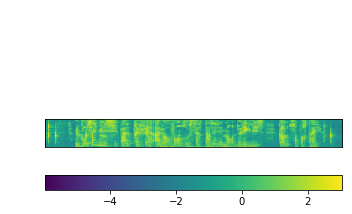

In [6]:
config = model.get_dataset_config(batch_size = 2, is_validation = True, shuffle_size = 0)
ds = prepare_dataset(valid.sample(25, random_state = 0), ** config, debug = True)

for batch in ds.take(5):
    (mel, mel_length), (text, text_length) = batch
    pred = model([mel, mel_length], training = False)
    pred = model.decode_output(pred)
    for m, p, t in zip(mel, pred, text):
        print("Encoded text : {}\nDecoded text : {}".format(t, model.decode_text(t)))
        print("Predicted : {}".format(p.replace('_', '')))
        plot_spectrogram(m)

## Tests

In [ ]:
a = tf.zeros((model.audio_rate * 10,))
mel = model.mel_fn(a)
print("Mel shape for 10 audio sec : {}".format(tf.shape(mel)))

## Prediction / search on file

Note : you can either use these cells to test your model right after training or use the `speech_to_text` notebook ;)

In [ ]:
filename = 'my_audio_file.mp3'
n = 30

display_audio(filename)
pred = model.predict(filename, overwrite = True, time_window = n, time_step = n, batch_size = 16)
pred[0]['alignment'][:10]

In [ ]:
keyword = ''
threshold = 0.85
res = model.search(keyword, filename, threshold = threshold)
print(res)

In [ ]:
res.display(before = 7.5)

In [ ]:
res.plot(False)